In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://media.githubusercontent.com/media/vvishan/tester/refs/heads/main/Data/creditcard.csv")


In [3]:
print(df['Class'].value_counts(normalize=True))

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


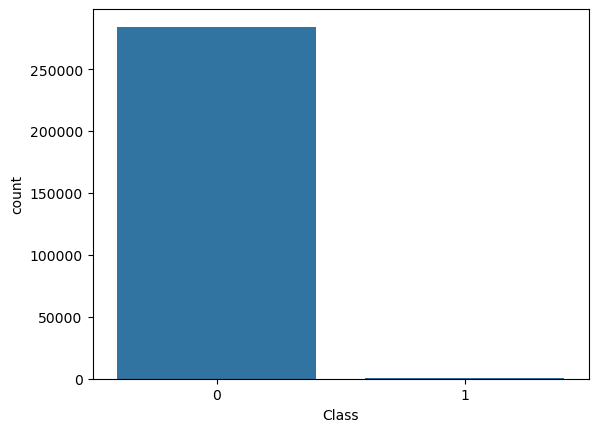

In [4]:
sns.countplot(x='Class',data = df)
plt.show()

In [5]:
df['Amount']

0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
           ...  
284802      0.77
284803     24.79
284804     67.88
284805     10.00
284806    217.00
Name: Amount, Length: 284807, dtype: float64

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
df['scaled_Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])


In [7]:
x = df.drop('Class',axis=1)
y = df['Class']


In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,stratify=y,random_state=42,test_size=0.2)

In [9]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train,Y_train)
Y_pred = lr.predict(X_test)
Y_proba = lr.predict_proba(X_test)[:,1]

In [10]:
from sklearn.metrics import classification_report,precision_recall_curve,roc_auc_score,average_precision_score,confusion_matrix

print(classification_report(Y_test,Y_pred))
print('ROC_AUC',roc_auc_score(Y_test,Y_proba))
print('PR_curve',average_precision_score(Y_test,Y_proba))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

ROC_AUC 0.9719938657792885
PR_curve 0.7204057827044144


In [11]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_proba)

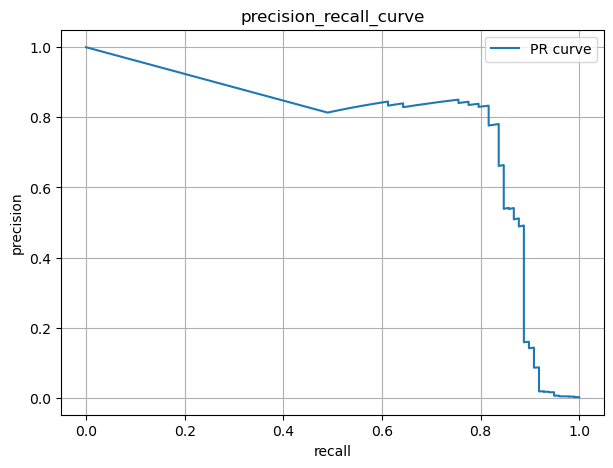

In [12]:
plt.figure(figsize=(7,5))
plt.plot(recall,precision, label ="PR curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
desired_recall = 0.90
print(recall[:-1])
valid_indx = np.where(recall[:-1] >= desired_recall)[0]
print(valid_indx)

[1.         1.         1.         ... 0.51020408 0.5        0.48979592]
[    0     1     2 ... 56270 56271 56272]


In [19]:
if len(valid_indx) > 0:
    best_idx = valid_indx[np.argmax(precision[valid_indx])]
    best_threshold = thresholds[best_idx]
    print(f"Best threshold with recall ≥ {desired_recall:.2f}: {best_threshold:.3f}")
else:
    print(f"No threshold gives recall ≥ {desired_recall:.2f}")


Best threshold with recall ≥ 0.90: 0.752


In [23]:
from sklearn.metrics import precision_score,recall_score,f1_score
selected_threshold =[0.5,0.7,0.8,0.9]
rows =[]
for t in sorted(set(selected_threshold+([best_threshold] if 'best_threshold' in locals() else []))):
    y_proba_t = (Y_proba >= t).astype(int)
    p = precision_score(Y_test,y_proba_t)
    r = recall_score(Y_test,y_proba_t)
    f1 = f1_score(Y_test,y_proba_t)
    cm = confusion_matrix(Y_test,y_proba_t)
    rows.append((t,p,r,f1,cm))

In [25]:
dff = pd.DataFrame(rows, columns=["threshold","precision","recall","f1","confusion matrics"])
print(dff)

   threshold  precision    recall        f1         confusion matrics
0   0.500000   0.061017  0.918367  0.114431  [[55479, 1385], [8, 90]]
1   0.700000   0.121419  0.908163  0.214200   [[56220, 644], [9, 89]]
2   0.751743   0.143087  0.908163  0.247222   [[56331, 533], [9, 89]]
3   0.800000   0.159633  0.887755  0.270607  [[56406, 458], [11, 87]]
4   0.900000   0.245070  0.887755  0.384106  [[56596, 268], [11, 87]]


In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

sm = SMOTE(random_state=42)
x_res,y_res = sm.fit_resample(X_train,Y_train)
oob_error =[]
for n in [50, 100, 200, 300]:
    rf = RandomForestClassifier(n_estimators=n,oob_score=True,class_weight=None,random_state=42,n_jobs=1)
    rf.fit(x_res,y_res)
    oob_error.append(1-rf.oob_score_)


plt.plot([50, 100, 200, 300], oob_error, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("OOB Error")
plt.title("Choosing n_estimators")
plt.show()

ModuleNotFoundError: No module named 'imblearn'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Test").getOrCreate()
#dff = spark.createDataFrame([(1,"Alice"),(2,"Bob")], ["id","name"])
#dff.show()

KeyboardInterrupt: 

In [5]:
import os, sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [8]:
import os, sys

# Use the same Python interpreter for driver and workers
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Force Spark local binding to localhost (avoid IPv6 / host resolution issues)
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[1]") \          # use a single core to avoid spawning many workers
    .appName("DebugTest") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.executorEnv.PYSPARK_PYTHON", sys.executable) \
    .config("spark.executorEnv.PYSPARK_DRIVER_PYTHON", sys.executable) \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.ui.enabled", "false") \    # disable UI to reduce chance of port conflicts
    .getOrCreate()

print("Driver python:", sys.executable)
print("SPARK_LOCAL_IP:", os.environ.get("SPARK_LOCAL_IP"))
print("Spark version:", spark.version)


SyntaxError: unexpected character after line continuation character (1876767905.py, line 13)